# PREPROCESSING

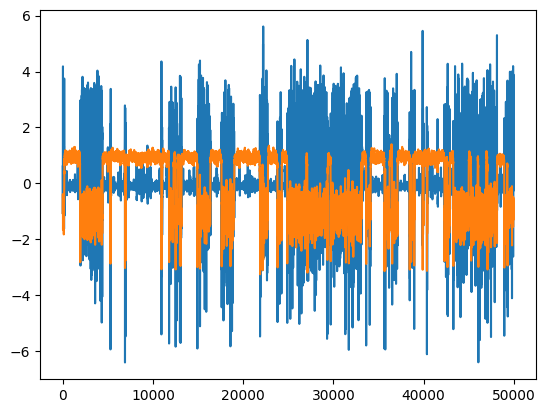

In [1]:
# Init pack

import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel

psi = np.load('/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy')

psi = psi[:,1,:]

# Normalization
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

# Pre-processing

lead = 1
trainN = 250000
valN = 50000
index = 63

# Defining the variable ranges
variable_range = [(0,24), (25, 49), (50, 74), (0, 49), (0,74)]

# Select the variable: 0 for real perturbation, 1 for imaginary perturbation, 2 for zonal winds
variable = 3
num_variables = variable_range[variable][1] - variable_range[variable][0] + 1

# Shuffle and map indices
np.random.seed(42)
valid_indices = np.arange(0, trainN - lead)
shuffled_indices = np.random.permutation(valid_indices)

# Now constrain the shuffled indices to the variable range
np_psi_train_input = psi[shuffled_indices, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_train_label = psi[shuffled_indices + lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label = torch.tensor(np_psi_train_label)

np_psi_val_input = psi[trainN:trainN+valN, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_val_label = psi[trainN+lead:trainN+valN+lead, :]
psi_val_input = torch.tensor(np_psi_val_input)
psi_val_label =  torch.tensor(np_psi_val_label)

plt.plot(np_psi_val_input[:,-1]) # Real and Imaginary PSI
plt.plot(np_psi_val_label[:,-1]) # Real and Imaginary PSI + Zonal Wind
plt.show()
# plt.plot(psi_val_input[0:50000,63])

In [2]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        # x = torch.relu(self.fc5(x)) + x
        # x = torch.relu(self.fc6(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        # z = torch.relu(self.fc5(z)) + z
        # z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

output_dim = 75
latent_dim = 32
condition_dim = num_variables
batch_size = 1024

# CHOOSING BY EXP FIT

In [3]:
from scipy.stats import linregress

import warnings
from torch.serialization import SourceChangeWarning
warnings.filterwarnings("ignore", category=UserWarning)

def normalize_transition_time(slope_value, delta, transition_real):
    normalized = 1 - np.exp(-np.abs((slope_value - transition_real)) / delta)
    return normalized

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

# Code from Ira Shokar but slightly changed
def crps_score(predictions, actual):

    actual  = actual.unsqueeze(0)
    # First term: mean distance from observations to ensemble members
    mae     = torch.cdist(actual, predictions, 1).mean()
    # Second term: mean distance between ensemble members (properly normalized)
    ens_var = torch.cdist(predictions, predictions, 1).mean()
    
    return mae - 0.5 * ens_var

# Function to calculate transition durations
def calculate_transition_durations(y_values, upper_bound, lower_bound):

    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False
    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:  
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:  
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None  
            above_upper = True
            below_lower = False

        if below_lower and transition_start is None:
            transition_start = i
    return times_between_transitions

def KL_coefficient(real_data, pred_mean, delta, cycle, KL_by_dim_cycle):

    # Calculating KL divergence
    KL_real_data = real_data[:30000, 1, 63]
    KL_predictions = pred_mean[:30000]
    KL_row = []
    
    actual_hist, bin_edges = np.histogram(KL_real_data, bins=50, density=True)
    pred_hist, _ = np.histogram(pred_mean, bins=bin_edges, density=True)

    epsilon = 1e-10
    actual_hist += epsilon
    pred_hist += epsilon

    # Calculate KL divergence between the two histograms
    KL = np.sum(actual_hist * np.log(actual_hist / pred_hist))

    norm_KL = normalize_transition_time(KL, 1, 0)
    print(f"Normalized KL divergence for delta {delta}, cycle {cycle}: {norm_KL:.6f}")
    KL_by_dim_cycle[delta][cycle].append(norm_KL)

    return KL_real_data, KL_predictions, norm_KL

def Slope_fit(pred_durations, slope_real, epoch):

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) > 0 and len(np.unique(pred_durations)) > 1:
        pred_data_sorted = np.sort(pred_durations)
        ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

        valid_indices_pred = ccdf_pred > 0
        x_fit_pred = pred_data_sorted[valid_indices_pred]
        y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

        slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)
        slope_diff_normalized = normalize_transition_time(slope_pred, 0.005, slope_real)
        return slope_diff_normalized

    else:
        print("No transitions detected in predictions for CCDF slope evaluation.")

def Mean_and_std_of_predictions(pred_durations, real_durations, delta, cycle, transitions_by_dim_cycle, transitions_normalized_by_dim_cycle, transitions_normalized_std_by_dim_cycle):
    transition_mean = np.mean(pred_durations)
    transition_std = np.std(pred_durations)

    transition_mean_diff = abs(transition_mean - np.mean(real_durations))
    transition_std_diff = abs(transition_std - np.std(real_durations))

    transition_mean_diff_normalized = normalize_transition_time(transition_mean_diff, 1000, np.mean(real_durations))
    transition_std_diff_normalized = normalize_transition_time(transition_std_diff, 1000, np.std(real_durations))

    if transition_std_diff_normalized == 0:
        transition_std_diff_normalized = 1

    transitions_by_dim_cycle[delta][cycle].append(transition_mean_diff)
    transitions_normalized_by_dim_cycle[delta][cycle].append(transition_mean_diff_normalized)
    transitions_normalized_std_by_dim_cycle[delta][cycle].append(transition_std_diff_normalized)

    return transition_mean_diff_normalized, transition_std_diff_normalized

# KL Annealing
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <=stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

In [4]:
from matplotlib import gridspec
import seaborn as sns
import os

def Timeseries_plot(actual, pred, epoch, ax):

    ax.plot(actual, 'b', label='Actual')
    ax.plot(pred, 'r', label='Predictions')

    ax.set_title(f"Timeseries | Epoch {epoch}", fontsize=16)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('Zonal Wind Value', fontsize=14)

    ax.legend(['Predictions', 'Actual'])
    ax.grid(True)

    # save_path = os.path.join(folder, "timeseries")
    # save_path = os.path.join(save_path, f"timeseries_plot_{epoch+1}.png")

    # plt.savefig(save_path)

    # plt.show()

def PDF_plot(actual, pred, epoch, pdf_distance, ax):

    sns.histplot(actual, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data', ax=ax)
    sns.histplot(pred, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions', ax=ax)

    ax.set_title(f"Probability Distribution Functions (PDFs) | Epoch {epoch} | KL Error: {pdf_distance:.4f}", fontsize=16)
    ax.set_xlabel('Zonal Wind (m/s)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    
    ax.axvline(np.mean(actual), color='black', linestyle='--', label=f'Real Mean: {np.mean(actual):.2f}')
    ax.axvline(np.mean(pred), color='red', linestyle='--', label=f'Pred Mean: {np.mean(pred):.2f}')

    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

    # save_path = os.path.join(folder, "bi_modal_distri")
    # save_path = os.path.join(save_path, f"bi_modal_distribution_plot_{epoch+1}.png")
    # plt.savefig(save_path)

    # plt.show()

def Exp_fit_plot(x_line_pred, y_values_pred, x_line_real, y_values_real, exponential_fit_pred, exponential_fit_real, epoch, exp_distance, range_distance, ax):

    ax.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)
    ax.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)

    ax.set_xlabel('Time Duration (Steps)')
    ax.set_ylabel('Exponential Fit')
    ax.set_title(f"Exponential Fits of Transition Return Periods | Epoch {epoch} | Exp Error: {exp_distance:.4f} | Range Error: {range_distance:.4f}", fontsize=16)
   
    ax.set_yscale("linear")  # y-axis log scale
    ax.set_xscale("linear")  # x-axis linear scale
    
    ax.grid()
    ax.legend()
    
    # save_path = os.path.join(folder, "expo_fit")
    # save_path = os.path.join(save_path, f"expo_fit_plot_{epoch}.png")
    # plt.savefig(save_path)
    # plt.show()

def Final_avg_transition_plot(transitions_by_dim_cycle, transition_real, delta, num_cycles, folder):

    plt.figure(figsize=(10, 6))
    for c in range(num_cycles):
        plt.plot(transitions_by_dim_cycle[delta][c], 'o-', label=f'Cycle {c}')
    
    plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')

    plt.xlabel('Epoch within Cycle')
    plt.ylabel('Average Transition Value')
    plt.ylim(0.1,2000)
    plt.title(f'Average Transition Progress (Delta Coefficient={delta})')
    plt.grid(True)
    plt.legend()

    save_path = os.path.join(folder, "summary")
    save_path = os.path.join(save_path, f"transition_plot_all_cycles.png")
    plt.savefig(save_path)

    plt.show()

def Final_exp_fit_plot(exp_fit_by_dim_cycle, exponential_fit_real, delta, num_cycles, folder):
    
    plt.figure(figsize=(10, 6))
    for c in range(num_cycles):
        plt.plot(exp_fit_by_dim_cycle[delta][c], 'o-', label=f'Cycle {c}')
    
    plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')

    plt.xlabel('Epoch within Cycle')
    plt.ylabel('Exponential Fit Value')
    plt.title(f'Exponential Fit Progress (Delta Coefficient={delta})')
    plt.grid(True)
    plt.legend()

    save_path = os.path.join(folder, "summary")
    save_path = os.path.join(save_path, f"exponential_fit_plot_all_cycles.png")
    plt.savefig(save_path)
    
    plt.show()

def all_plot(actual, pred, x_line_pred, y_values_pred, x_line_real, y_values_real, 
             exponential_fit_pred, exponential_fit_real, pdf_distance, exp_distance, range_distance, epoch, folder):
    
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,1], height_ratios=[1,1])

    ax_timmeseries = fig.add_subplot(gs[:, 0])
    ax_pdf = fig.add_subplot(gs[0, 1])
    ax_exp_fit = fig.add_subplot(gs[1, 1])

    Timeseries_plot(actual, pred, epoch, ax_timmeseries)
    PDF_plot(actual, pred, epoch, pdf_distance, ax_pdf)
    Exp_fit_plot(x_line_pred, y_values_pred, x_line_real, y_values_real, 
                 exponential_fit_pred, exponential_fit_real, epoch, exp_distance, range_distance, ax_exp_fit)
    
    distance = np.sqrt(pdf_distance**2 + exp_distance**2 + range_distance**2)
    fig.suptitle(f"Predictions vs Actual | Epoch {epoch} | Euclidean Metric Error: {distance}", fontsize=20)
    plt.subplots_adjust(wspace=0.2, hspace=0.35)  # Adjust these values as desired
    fig.tight_layout(pad=2.0)
    plt.savefig(os.path.join(folder, f"plots/all_plots_epoch_{epoch+1}.png"))
    plt.show()

def Loss_plot(losses_training, losses_validation, cycle, delta, folder):

    plt.figure(figsize=(10,6))

    plt.plot(losses_training, label='Training Loss')
    plt.plot(losses_validation, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Losses for Cycle {cycle+1} with Delta {delta}')
    plt.legend()

    save_path = os.path.join(folder, "summary")
    save_path = os.path.join(save_path, f"loss_plot_cycle_{cycle+1}_delta_{delta}.png")
    plt.savefig(save_path)
    
    plt.show()

In [5]:
beta_kl_coef = frange_cycle_linear(0.01, 0.3, 50, 1, 1)
print(beta_kl_coef)
num_epochs = 50

[0.01   0.0158 0.0216 0.0274 0.0332 0.039  0.0448 0.0506 0.0564 0.0622
 0.068  0.0738 0.0796 0.0854 0.0912 0.097  0.1028 0.1086 0.1144 0.1202
 0.126  0.1318 0.1376 0.1434 0.1492 0.155  0.1608 0.1666 0.1724 0.1782
 0.184  0.1898 0.1956 0.2014 0.2072 0.213  0.2188 0.2246 0.2304 0.2362
 0.242  0.2478 0.2536 0.2594 0.2652 0.271  0.2768 0.2826 0.2884 0.2942]


Reference Real Data average_transition_time: 759.8341708542714
Reference Real Data CCDF Slope: -0.001349964964925677
USING DELTA COEF OF 1
Loading model from /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_DELTA_TEST_base_1000_epoch/model_at_0_with_delta_1/checkpoint_1000


/tmp/ipykernel_20352/969023186.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1, 
                Reconstrunction Loss: 0.002884593792259693
                KL Loss: 5.012750534660881e-07
                CRPS Loss: 0.004046386573463678
                Total Loss: 0.00288509507663548
                

                Validation Reconstrunction Loss: 0.008908812887966633
                Validation KL Loss: 2.9292702947714133e-06
                Validation CRPS Loss: 0.004016667604446411
                Validation Total Loss: 0.008911741897463799
Normalized KL divergence for delta 1, cycle 0: 0.623852
Exponential Fit Normalized: 0.197008
Duration Difference Normalized: 0.321180


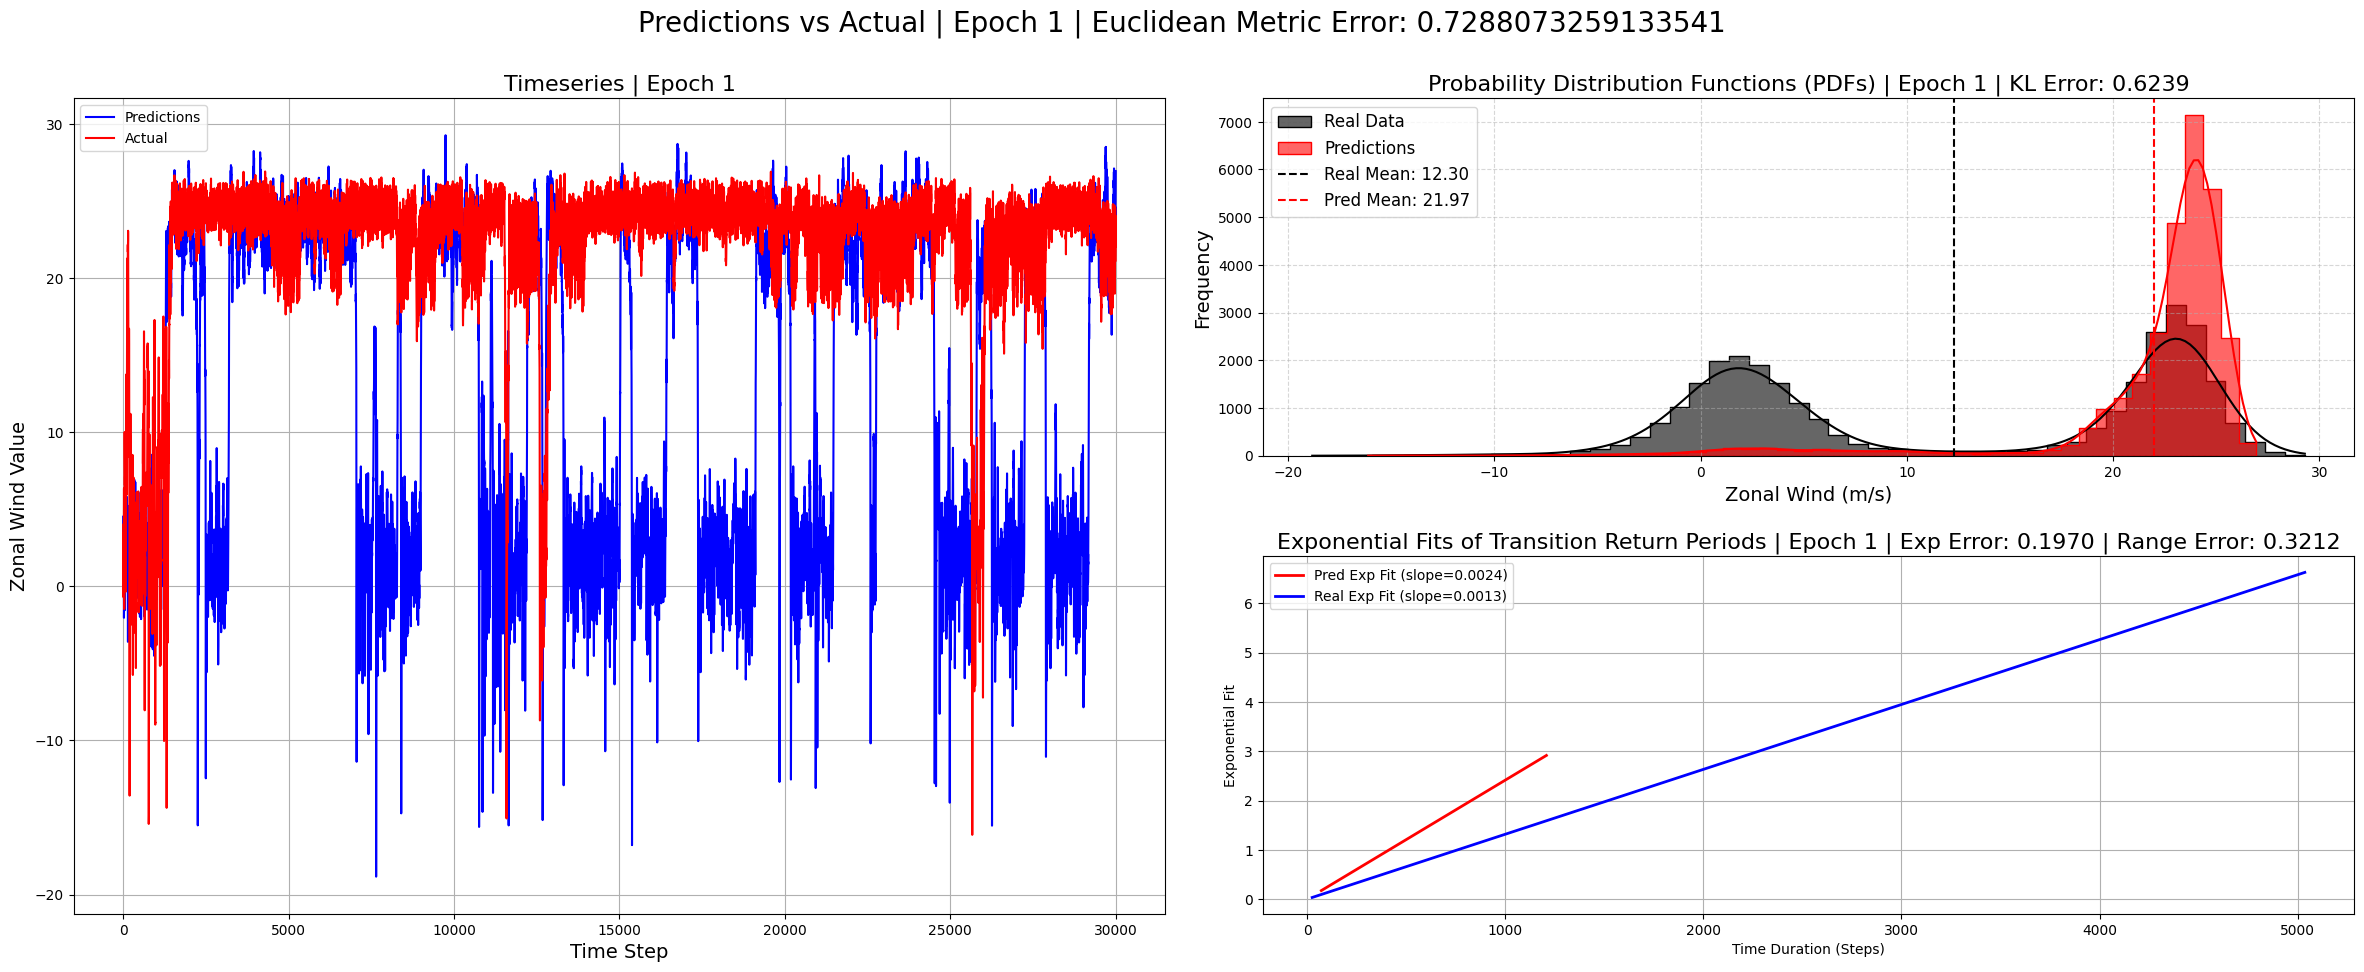

Epoch 1: Exponential Transition Fit Predictions Normalized: 0.1970077009397474, KL Normalized = 0.6238518884502755, Duration Difference Normalized = 0.3211804871912892, Combined Distance = 0.728807
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_DELTA_TEST_at_2025-06-20 17:18:52.180355/model_at_0_with_delta_1 with point 1.
Epoch 2, 
                Reconstrunction Loss: 0.002710889559239149
                KL Loss: 1.0956829100905452e-05
                CRPS Loss: 0.004045864101499319
                Total Loss: 0.0027218463364988565
                

                Validation Reconstrunction Loss: 0.008701671846210957
                Validation KL Loss: 6.524561467813328e-05
                Validation CRPS Loss: 0.004016080871224403
                Validation Total Loss: 0.008766917511820793
Normalized KL divergence for delta 1, cycle 0: 0.765266
Exponential Fit Normalized: 0.113884
Duration D

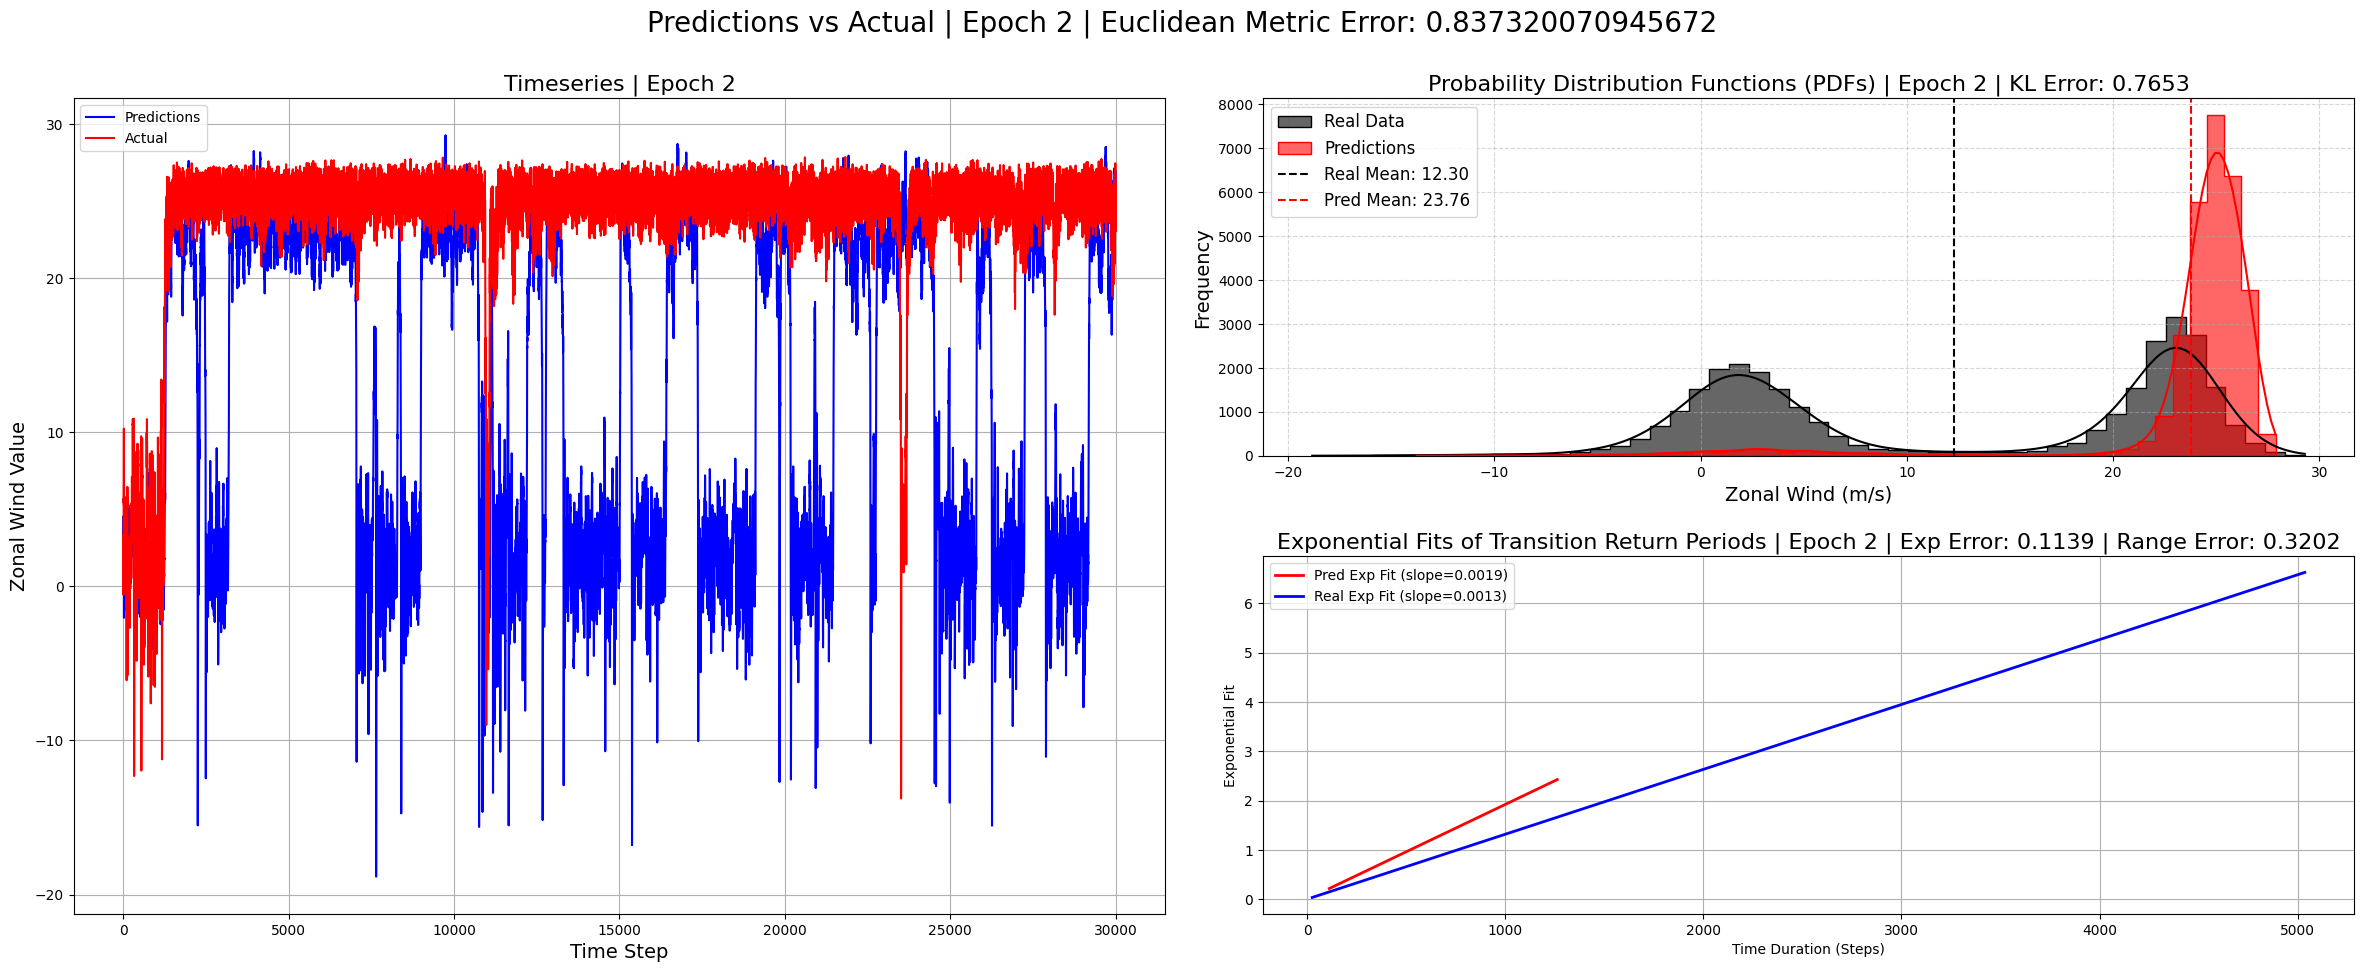

Epoch 2: Exponential Transition Fit Predictions Normalized: 0.11388415999913382, KL Normalized = 0.7652659127086967, Duration Difference Normalized = 0.32016149386814496, Combined Distance = 0.837320
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_DELTA_TEST_at_2025-06-20 17:18:52.180355/model_at_0_with_delta_1 with point 2.
Epoch 3, 
                Reconstrunction Loss: 0.002743195276707411
                KL Loss: 1.0235310128337005e-06
                CRPS Loss: 0.004045937210321426
                Total Loss: 0.0027442188002169132
                

                Validation Reconstrunction Loss: 0.008704877458512783
                Validation KL Loss: 6.301474513747962e-06
                Validation CRPS Loss: 0.004015977960079908
                Validation Total Loss: 0.008711178787052631
Normalized KL divergence for delta 1, cycle 0: 0.672521
No transitions detected in predictions for CC

KeyboardInterrupt: 

In [30]:
# TO-DO: Try to change KL metric to KS. Add all graphs in one figure and add the distance metric to the best model selection to it.

# Training

torch.cuda.empty_cache()

import datetime
import os
import shutil
from scipy.stats import linregress
import seaborn as sns
from matplotlib.gridspec import GridSpec

def model_restore(model_path, model):
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))

def inference(model, psi, mean_psi, std_psi, time_step, variable_range, variable, num_variables, latent_dim):
    start, end = variable_range[variable][0], variable_range[variable][1]+1
    initial_cond = torch.reshape(torch.tensor(psi[0,start:end]), [1, num_variables])
    z = torch.zeros([1,latent_dim])
    pred = np.zeros ([time_step, 75])

    for k in range (0, time_step):

        with torch.inference_mode():
            model.eval()

            with autocast(device_type='cuda'):

                if (k ==0):

                    z = torch.randn_like(z).float().cuda(non_blocking=True)
                    initial_cond = initial_cond.float().cuda(non_blocking=True)

                    y = (model.decode(z,initial_cond)).detach().cpu().numpy()
                    pred[k,:] = y

                    y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                    initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

                else:
                    z = torch.randn_like(z).float().cuda(non_blocking=True)
                    initial_cond = torch.reshape(torch.tensor(pred[k-1,start:end]),[1,num_variables]).float().cuda(non_blocking=True)

                    y = (model.decode(z,initial_cond)).detach().cpu().numpy()
                    pred[k,:] = y

                    y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                    initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])
    
    return pred

def euclidean_distance_for_predictions(metrics):
    sum = 0
    for metric in metrics:
        sum += metric ** 2
    distance = np.sqrt(sum)
    return distance

def save_best_cycle_epoch(models, delta, cycle, epoch, 
                          exp_fit_normalized_by_dim_cycle, 
                          KL_by_dim_cycle, duration_diff_by_dim_cycle, 
                          best_models_saved, best_models):
    
    best_model = None
    best_index = -1
    best_distance = float('inf')

    for i in range(len(models)):  # models contains each epoch's model in the current cycle

        metrics = [exp_fit_normalized_by_dim_cycle[delta][cycle][i],
                   KL_by_dim_cycle[delta][cycle][i], 
                   duration_diff_by_dim_cycle[delta][cycle][i]]
        
        distance = euclidean_distance_for_predictions(metrics)
        if distance < best_distance:
            best_distance = distance
            shutil.copyfile(models[i], f"{folder}/best_model_combined_distance_at_cycle_{cycle}_and_checkpoint_{epoch}.pth")
            print(f"New best model saved with distance {distance:.4f} at epoch {i+1}")
            best_index = i
            best_model = models[i]

    if best_index != -1:
        best_models_saved.append(best_model)
        best_models.append((cycle, best_index))

def save_best_epoch(best_models, best_models_saved, exp_fit_normalized_by_dim_cycle,
                    KL_by_dim_cycle, duration_diff_by_dim_cycle, delta, master_folder):
    
    print("Selecting the best model based on combined distance...")

    # Ensure best_models is not empty
    if not best_models:
        print("No best models found.")
        return
    
    # After all cycles - final best model selection
    best_model = None
    where_model = (-1, -1)
    best_model_distance = float('inf')

    print(f"Number of best models saved: {len(best_models)}")
    for idx, (cycle_num, epoch_idx) in enumerate(best_models):

        metrics = [exp_fit_normalized_by_dim_cycle[delta][cycle_num][epoch_idx], 
                   KL_by_dim_cycle[delta][cycle_num][epoch_idx], 
                   duration_diff_by_dim_cycle[delta][cycle_num][epoch_idx]]
        
        distance = euclidean_distance_for_predictions(metrics)        
        print(f"Distance for model from cycle {cycle_num+1}, epoch {epoch_idx+1}: {distance:.4f}")
        print(f"Current best distance: {best_model_distance:.4f}")
        
        if distance < best_model_distance:
            best_model_distance = distance
            best_model = best_models_saved[idx]
            where_model = (cycle_num, epoch_idx)

    # Save the best model  
    i,n = where_model
    cycle = i
    epoch = n

    if cycle == -1:
        print("No best model found.")
    else:
        shutil.copyfile(best_model, f"{master_folder}/best_model_combined_distance_with_cycle_{cycle+1}_and_epoch_{epoch+1}.pth")
        print(f"Best model saved with cycle {cycle+1} and epoch {epoch+1}.")

# Initialization
scaler          = GradScaler()

latent_dims     = [1024]
latent_dim      = 32
kl_coefficients = [0.1]
kl_coef         = 0.1
delta_coefs     = [1]
time_step       = 30000
num_cycles      = 1
ens_size        = 1
level           = 63
upper_bound     = 53.8 / 2.8935
lower_bound     = 7.41

TRAIN_N         = 250000
VAL_N           = 50000

restore         = True

best_distance   = float('inf')

real_data       = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
real_data_1d    = real_data[:, 1, level]

# Function to calculate transition durations
real_durations      = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted    = np.sort(real_durations)
transition_real     = np.mean(real_data_sorted)

actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

# Compute CCDF slope for real data
ccdf_real           = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)
valid_indices_real  = ccdf_real > 0
x_fit_real          = real_data_sorted[valid_indices_real]
y_fit_real          = np.log(ccdf_real[valid_indices_real])
slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)
print(f"Reference Real Data CCDF Slope: {slope_real}")

# Compute exponential fit for real data
x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
exponential_fit_real = 1/np.mean(real_data_sorted)
y_values_real = exponential_fit_real*x_line_real

# Initialize dictionaries to store results
transitions_by_dim_cycle                = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
transitions_normalized_by_dim_cycle     = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
transitions_normalized_std_by_dim_cycle = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
duration_diff_by_dim_cycle              = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
slope_diff_by_dim_cycle                 = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
exp_fit_by_dim_cycle                    = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
exp_fit_normalized_by_dim_cycle         = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}
KL_by_dim_cycle                         = {dl: {cycle: [] for cycle in range(num_cycles)} for dl in delta_coefs}

models_by_dim_cycle = []
master_folder = f"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_DELTA_TEST_at_{datetime.datetime.now()}"
os.makedirs(master_folder)

for delta in delta_coefs:
    print(f"USING DELTA COEF OF {delta}")

    best_models         = []
    best_models_saved   = []

    losses_training     = []
    losses_validation   = []

    for cycle in range(0,num_cycles):

        models = []

        # Initialize the model, optimizer, and loss function
        model       = ConditionalVAE(latent_dim, output_dim, condition_dim)
        model       = model.cuda()
        optimizer   = optim.Adam(model.parameters(), lr=0.0001)

        # Create the folder structure for saving results
        subfolders  = ['plots','checkpoints']
        folder      = f"{master_folder}/model_at_{cycle}_with_delta_{delta}"
        os.makedirs(folder)
        for subfolder in subfolders:
            path = os.path.join(folder, subfolder)
            os.mkdir(path)

        # Restore the model if specified
        if restore:
            model_path = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_DELTA_TEST_base_1000_epoch/model_at_0_with_delta_1/checkpoint_1000"
            model_restore(model_path, model)
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for batch in range (0, TRAIN_N, batch_size):
                
                input_batch = psi_train_input[batch:batch + batch_size,:]
                label_batch = psi_train_label[batch:batch + batch_size,:]

                optimizer.zero_grad()

                with autocast(device_type='cuda'):
                    outputs, mus, logvars = zip(*[model(label_batch.float().cuda(non_blocking=True), input_batch.float().cuda(non_blocking=True)) for _ in range(ens_size)])
                    output = torch.stack(outputs)
                    mu = torch.stack(mus)
                    logvar = torch.stack(logvars)

                    reconstruction_loss = F.smooth_l1_loss(output, label_batch.float().cuda(non_blocking=True), reduction="mean")
                    crps_loss = crps_score(output, label_batch.float().cuda(non_blocking=True)) * 0.0001
                    kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum() * beta_kl_coef[epoch]

                    # Total loss
                    loss = reconstruction_loss + kl_loss + 0*crps_loss
                    
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            losses_training.append(loss.item())
            print(f'''Epoch {epoch+1}, 
                Reconstrunction Loss: {reconstruction_loss.item()}
                KL Loss: {kl_loss.item()}
                CRPS Loss: {crps_loss.item()}
                Total Loss: {loss.item()}
                ''')

            # Validation Loss
            for batch in range (0, VAL_N, batch_size):

                model.eval()
                input_batch = psi_val_input[batch:batch + batch_size,:]
                label_batch = psi_val_label[batch:batch + batch_size,:]

                with torch.no_grad():
                    with autocast(device_type='cuda'):
                        outputs, mus, logvars = zip(*[model(label_batch.float().cuda(non_blocking=True), input_batch.float().cuda(non_blocking=True)) for _ in range(ens_size)])
                        output = torch.stack(outputs)
                        mu = torch.stack(mus)
                        logvar = torch.stack(logvars)

                        val_reconstruction_loss = F.smooth_l1_loss(output, label_batch.float().cuda(non_blocking=True), reduction="mean")
                        crps_loss = crps_score(output, label_batch.float().cuda(non_blocking=True)) * 0.0001
                        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum() * beta_kl_coef[epoch]  
                
                # Total loss
                val_loss = val_reconstruction_loss + kl_loss + 0*crps_loss

            losses_validation.append(val_loss.item())
            print(f'''
                Validation Reconstrunction Loss: {val_reconstruction_loss.item()}
                Validation KL Loss: {kl_loss.item()}
                Validation CRPS Loss: {crps_loss.item()}
                Validation Total Loss: {val_loss.item()}''')
            
            # Inference
            pred = inference(model, psi, mean_psi, std_psi, 
                             time_step, variable_range, variable, 
                             num_variables, latent_dim)
                
            # Denormalize final preds
            pred_mean = pred[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
            actual_values = psi[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
            predictions_1d = pred_mean[:, 63]  # shape (300000,)

            # # Plotting the timeseries
            # Timeseries_plot(actual_values[:30000, 63], 
            #                 predictions_1d[:30000], 
            #                 epoch, folder)
            
            # Calculate transition durations for predictions
            pred_durations = calculate_transition_durations(predictions_1d, 
                                                            upper_bound, 
                                                            lower_bound)

            # Calculate KL coefficient
            KL_real_data, KL_predictions, avg_norm_KL = KL_coefficient(real_data, 
                                                                           predictions_1d, 
                                                                           delta, 
                                                                           cycle, 
                                                                           KL_by_dim_cycle)
            
            # # Plotting the PDFs
            # PDF_plot(KL_real_data, 
            #          KL_predictions, 
            #          epoch, folder)

            # Calculate mean and standard deviation of predictions
            transition_diff_normalized, transition_std_diff_normalized = Mean_and_std_of_predictions(pred_durations, 
                                                                                                     real_durations, 
                                                                                                     delta, cycle,
                                                                                                     transitions_by_dim_cycle,
                                                                                                     transitions_normalized_by_dim_cycle,
                                                                                                     transitions_normalized_std_by_dim_cycle)

            # Calculate the difference between exponential fits
            slope_diff_normalized = 1
            slope_diff_normalized = Slope_fit(pred_durations, slope_real, epoch)
            slope_diff_by_dim_cycle[delta][cycle].append(slope_diff_normalized)

            # Initialize variables for exponential fit and range of transitions
            exponential_fit_pred = 0
            duration_diff_normalized = 1

            if len(pred_durations) > 0 and  len(np.unique(pred_durations)) > 1:

                # Calculate the exponential fit for predictions
                x_line_pred = np.linspace(min(pred_durations), max(pred_durations), 100)
                exponential_fit_pred = 1/np.mean(pred_durations)
                exp_fit_by_dim_cycle[delta][cycle].append(exponential_fit_pred)
                exp_fit_normalized = normalize_transition_time(exponential_fit_pred, 0.005, exponential_fit_real)
                print(f"Exponential Fit Normalized: {exp_fit_normalized:.6f}")

                # Calculate the y-values for the exponential fit
                y_values_pred = exponential_fit_pred*x_line_pred

                # Plot the exponential fit for predictions
                # Exp_fit_plot(x_line_pred, y_values_pred, x_line_real, y_values_real, exponential_fit_pred, exponential_fit_real, epoch+1, folder)

                # Calculate the range of transitions
                max_pred = np.max(pred_durations)
                min_pred = np.min(pred_durations)
                
                if max_pred > 0:

                    # Calculate the predicted range and normalize it
                    difference = abs(max_pred - min_pred)
                    duration_diff_normalized = normalize_transition_time(difference, 10000, abs(np.max(real_durations)-np.min(real_durations)))
                    duration_diff_by_dim_cycle[delta][cycle].append(duration_diff_normalized)
                    print(f"Duration Difference Normalized: {duration_diff_normalized:.6f}")
                    all_plot(actual_values[:30000, 63],
                                predictions_1d[:30000], 
                                x_line_pred, y_values_pred, 
                                x_line_real, y_values_real, 
                                exponential_fit_pred, exponential_fit_real, avg_norm_KL,
                                exp_fit_normalized, duration_diff_normalized,
                                epoch+1, folder)
                    
                else:
                    print("No distribution of transitions detected in predictions.")
            else:
                exp_fit_by_dim_cycle[delta][cycle].append(exponential_fit_pred)
                duration_diff_by_dim_cycle[delta][cycle].append(duration_diff_normalized)
                exp_fit_normalized = normalize_transition_time(exponential_fit_pred, 0.005, exponential_fit_real)
                exp_fit_normalized_by_dim_cycle[delta][cycle].append(exp_fit_normalized)
                print("No transitions detected in predictions for exponential fit evaluation.")



            # Calculate accuracy by euclidean distance with specified metrics
            metrics = [exp_fit_normalized, avg_norm_KL, duration_diff_normalized]
            distance = euclidean_distance_for_predictions(metrics)
            print(f"Epoch {epoch+1}: Exponential Transition Fit Predictions Normalized: {exp_fit_normalized}, KL Normalized = {avg_norm_KL}, Duration Difference Normalized = {duration_diff_normalized}, Combined Distance = {distance:.6f}")
            
            # Save the model weights at each epoch
            path = f"{folder}/checkpoints/checkpoint_{epoch+1}"
            torch.save(model.state_dict(), path)
            print(f"Model weights saved to {folder} with point {epoch+1}.")
            models.append(path)

            # Final plots if last epoch
            if epoch == num_epochs - 1:

                # Plot the final average transition plot
                Final_avg_transition_plot(transitions_by_dim_cycle, transition_real, delta, num_cycles, folder)
                
                # Plot the final exponential fit plot
                Final_exp_fit_plot(exp_fit_by_dim_cycle, exponential_fit_real, delta, num_cycles, folder)
        
        # Save the best model for the current cycle
        save_best_cycle_epoch(models, delta, cycle, epoch, exp_fit_normalized_by_dim_cycle, 
                              KL_by_dim_cycle, duration_diff_by_dim_cycle,
                              best_models_saved, best_models)

        Loss_plot(losses_training, losses_validation, cycle, delta, folder)
# Save the best model after all cycles
save_best_epoch(best_models, best_models_saved, exp_fit_normalized_by_dim_cycle,
                KL_by_dim_cycle, duration_diff_by_dim_cycle, delta, master_folder)

# INFERENCE

In [14]:
# Inference
# Inference
import datetime
import os

# Initialize the model, optimizer, and loss function
latent_dim = 32
output_dim = 75
condition_dim = num_variables
model = ConditionalVAE(latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
start, end = variable_range[variable][0], variable_range[variable][1]+1

# MODIFY THIS LINE FOR MODEL TESTING
past_model = True  # Set to True if you want to load past model weights
if past_model:
    model_weights_path = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/best_models_kinda/June23th.pth"
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))
        print(f"Model weights loaded from {model_weights_path}.")

for _ in range (0,1):

    start, end = variable_range[variable][0], variable_range[variable][1]+1
    initial_cond = torch.reshape(torch.tensor(psi[0,start:end]), [1, num_variables])
    print(initial_cond.shape)
    time_step = 300000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)
                print(z.shape, initial_cond.shape)
                y = (model.decode(z.float().cuda(non_blocking=True),initial_cond.float().cuda(non_blocking=True))).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(non_blocking=True),torch.reshape(torch.tensor(pred[k-1,start:end,select_ens]),[1,num_variables]).float().cuda(non_blocking=True))).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

    # Denormalize final preds
    pred = pred.reshape(pred.shape[0], pred.shape[1])
    print(pred.shape, psi.shape)
    pred_mean = pred[:300000, :] * std_psi[:, :] + mean_psi[:, :]
    
    # Denormalize test labels
    actual_values = psi[:300000, :] * std_psi[:, :] + mean_psi[:, :]
    print(actual_values)

    plt.figure(figsize=(20,8))
    plt.plot(pred_mean[0:30000, 63],'r')
    plt.plot(actual_values[0:30000, 63],'b')
    plt.grid(True)
    plt.title(f"Predictions vs Actual")
    plt.savefig(f'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/prediction_vs_actual_{datetime.datetime.now()}.png')
    plt.show()

    # MODIFY THIS LINE FOR MODEL TESTING
    np.save(f'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/predictions_best_checkpoint_and_cycle_Resnet_VAE_8_temp.npy', pred_mean)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# TESTS

In [15]:
#FLAGS to determine testing
plot_data = 1
#what level do you want to plot
level = 63
CCDF = 1
Bi_modal_distribution = 1
single_step_profiles = 1
#for the single_step_profiles
NUM_SAMPLES = 5
#what weights do you want to use?
MODEL_PATH = r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/best_models_kinda/June23th.pth"
LEVEL = 63

import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Load the data; shape = (300000, 2, 75)
real_data = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
predictions = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/predictions_best_checkpoint_and_cycle_Resnet_VAE_8_temp.npy")

#reshape the predictions so that it matches the real_data shape
print(predictions.shape)
print(real_data.shape)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"
os.mkdir(folder)
subfolders = ['timeseries', 'CCDF', 'bi_modal_distribution', 'single_step_profiles']
# Create each subdirectory inside the main folder
for subfolder in subfolders:
    path = os.path.join(folder, subfolder)
    os.mkdir(path)
    print(f"Created subfolder: {path}")
SAVE_DIR = os.path.join(folder, "single_step_profiles")
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random

model = ConditionalVAE(latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# MODIFY THIS LINE FOR MODEL TESTING
model_weights_path = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_lat1024_at_2025-04-11 12:46:39.526973/model_at_0/checkpoint_3"

if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path))
    print(f"Model weights loaded from {model_weights_path}.")
    
if (plot_data):
    #note that the value 300000 will have to change depending on the real and predictions data length
    u_profile_real = real_data[:300000, 1, level]  # Match time length with predictions
    u_profile_pred = predictions[:, level]
    time_steps = np.arange(len(u_profile_pred))

    # === Plot ===
    plt.figure(figsize=(14, 6))

    plt.plot(time_steps, u_profile_real, label='Real Data', alpha=0.7)
    plt.plot(time_steps, u_profile_pred, label='Predictions', linestyle='--')


    # Labels, legend, and formatting
    plt.xlabel('Time step')
    plt.ylabel('U (m/s)')
    plt.title(f'Time Series of U at Vertical Level {level}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "timeseries")
    save_path = os.path.join(save_path, "real_prediction_plot")
    plt.savefig(save_path)
    plt.show()

if (CCDF):
    real_data_1d = real_data[:, 1, 63]  # Now shape is (309700,)
    predictions_1d = predictions[:, 63]  # shape (300000,)

    # Define bounds (assuming they apply to both datasets)
    upper_bound = 53.8 / 2.8935
    lower_bound = 7.41

    # Function to calculate transition durations
    def calculate_transition_durations(y_values, upper_bound, lower_bound):
        times_between_transitions = []
        transition_start = None
        above_upper = False
        below_lower = False

        for i in range(1, len(y_values)):
            if y_values[i] < lower_bound:  
                below_lower = True
                above_upper = False
            elif y_values[i] > upper_bound:  
                if below_lower and transition_start is not None:
                    times_between_transitions.append(i - transition_start)
                    transition_start = None  
                above_upper = True
                below_lower = False

            if below_lower and transition_start is None:
                transition_start = i

        return times_between_transitions

    # Compute transition durations for real data
    real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

    # Plot setup
    plt.figure(figsize=(10, 6))

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
        exponential_fit_real = 1/np.mean(real_data_sorted)
        y_values_real = exponential_fit_real*x_line_real
        plt.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        x_line_pred = np.linspace(min(pred_data_sorted), max(pred_data_sorted), 100)
        exponential_fit_pred = 1/np.mean(pred_data_sorted)
        y_values_pred = exponential_fit_pred*x_line_pred
        plt.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)

    print(1/np.mean(real_data_sorted))
    print(1/np.mean(pred_data_sorted))
    # Plot labels and formatting
    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("linear")  # y-axis log scale
    plt.xscale("linear")  # x-axis linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(folder, "CCDF")
    save_path = os.path.join(save_path, "CCDF_plot")
    plt.savefig(save_path)
    plt.show()
if (Bi_modal_distribution):
    zonal_wind_data_real = real_data[:, 1, 63]  # variable index 1 (e.g., zonal wind), level 60
    zonal_wind_data_predictions = predictions[:, 63]  # variable index 0 (predictions), level 60

    print(f"Shape of zonal_wind_data_real: {zonal_wind_data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {zonal_wind_data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(zonal_wind_data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(zonal_wind_data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title('Distribution of Zonal Winds For Real Data and Predictions', fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(zonal_wind_data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(zonal_wind_data_real):.2f}')
    plt.axvline(np.mean(zonal_wind_data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(zonal_wind_data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()
if (single_step_profiles):
    # Ensure save directory exists
    os.makedirs(SAVE_DIR, exist_ok=True)

    # === Load model weights ===
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    # === Randomly sample time points from real data ===
    time_indices = random.sample(range(0, real_data.shape[0] - 2), NUM_SAMPLES)
    print(f"Randomly sampled time steps: {time_indices}")

    # === Time series visualization ===
    real_data_timeseries = real_data[:, 1, LEVEL]
    time_steps_all = np.arange(len(real_data_timeseries))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps_all, real_data_timeseries, label="Real Data at Level 61", color='blue')

    # Mark sample points
    for idx_num, idx in enumerate(time_indices):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=2)
    if len(time_indices) > 0:
        plt.axvline(x=time_indices[0], color='green', linestyle='--', linewidth=2, label='Sampled Points')

    plt.title("Real Data Time Series with Sampled Points Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel("U (m/s) at Level 61")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(SAVE_DIR, "real_data_timeseries_with_samples.png")
    plt.savefig(save_path)
    plt.show()

    # === Iterate over each sampled time point ===
    for i, time_step in enumerate(time_indices):
        next_time_step = time_step + 1

        # === Real data: current and next ===
        real_current = real_data[time_step, 1, :]       
        real_next = real_data[next_time_step, 1, :]      

        # === Normalize real_current and make prediction for next step ===
        initial_cond = torch.reshape(torch.tensor(psi[time_step,start:end]), [1, num_variables])
        z = torch.zeros([1,latent_dim])
        num_ens = 1
        pred = np.zeros ([time_step, 75, num_ens])

        with torch.no_grad():
            z = torch.randn_like(z)
            print(z.shape, initial_cond.shape)
            y = (model.decode(z.float().cuda(non_blocking=True),initial_cond.float().cuda(non_blocking=True))).detach().cpu().numpy()

        # === Denormalize predicted next ===
        pred_next_denorm = y.squeeze() * std_psi.squeeze() + mean_psi.squeeze()

        # === Extract U, Re(Psi), Im(Psi) components ===
        # U profiles
        U_current_real = real_current[51:74]
        U_next_real = real_next[51:74]
        U_next_pred = pred_next_denorm[51:74]

        # Re(Psi) profiles
        RePsi_current_real = real_current[0:24]
        RePsi_next_real = real_next[0:24]
        RePsi_next_pred = pred_next_denorm[0:24]

        # Im(Psi) profiles
        ImPsi_current_real = real_current[25:50]
        ImPsi_next_real = real_next[25:50]
        ImPsi_next_pred = pred_next_denorm[25:50]

        # === Differences ===
        U_diff_real = U_next_real - U_current_real
        U_diff_pred = U_next_pred - U_current_real

        RePsi_diff_real = RePsi_next_real - RePsi_current_real
        RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

        ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
        ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

        # === Create a single figure with 3 rows (U, Re(Psi), Im(Psi)) ===
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns (Profile and Difference)

        z_levels_U = np.linspace(0, 70, 23)
        z_levels_RePsi = np.linspace(0, 70, 24)
        z_levels_ImPsi = np.linspace(0, 70, 25)

        # --- U ---
        axes[0, 0].plot(U_current_real, z_levels_U, 'x-', label="Real Current")
        axes[0, 0].plot(U_next_real, z_levels_U, 'd-', label="Real Next")
        axes[0, 0].plot(U_next_pred, z_levels_U, 's--', label="Predicted Next")
        axes[0, 0].set_title(f"U Profiles @ Step {time_step}")
        axes[0, 0].set_xlabel("U (m/s)")
        axes[0, 0].set_ylabel("Vertical Levels (km)")
        axes[0, 0].legend()

        axes[0, 1].plot(U_diff_real, z_levels_U, 'xb', label="Real Δ (Next - Current)")
        axes[0, 1].plot(U_diff_pred, z_levels_U, 'o--r', label="Pred Δ (Next - Current)")
        axes[0, 1].set_title("U Difference (Next - Current)")
        axes[0, 1].set_xlabel("ΔU (m/s)")
        axes[0, 1].legend()

        # --- Re(Psi) ---
        axes[1, 0].plot(RePsi_current_real, z_levels_RePsi, 'x-', label="Real Current")
        axes[1, 0].plot(RePsi_next_real, z_levels_RePsi, 'd-', label="Real Next")
        axes[1, 0].plot(RePsi_next_pred, z_levels_RePsi, 's--', label="Predicted Next")
        axes[1, 0].set_title(f"Re(Psi) Profiles @ Step {time_step}")
        axes[1, 0].set_xlabel("Re(Psi)")
        axes[1, 0].set_ylabel("Vertical Levels (km)")
        axes[1, 0].legend()

        axes[1, 1].plot(RePsi_diff_real, z_levels_RePsi, 'xb', label="Real Δ (Next - Current)")
        axes[1, 1].plot(RePsi_diff_pred, z_levels_RePsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[1, 1].set_title("Re(Psi) Difference (Next - Current)")
        axes[1, 1].set_xlabel("ΔRe(Psi)")
        axes[1, 1].legend()

        # --- Im(Psi) ---
        axes[2, 0].plot(ImPsi_current_real, z_levels_ImPsi, 'x-', label="Real Current")
        axes[2, 0].plot(ImPsi_next_real, z_levels_ImPsi, 'd-', label="Real Next")
        axes[2, 0].plot(ImPsi_next_pred, z_levels_ImPsi, 's--', label="Predicted Next")
        axes[2, 0].set_title(f"Im(Psi) Profiles @ Step {time_step}")
        axes[2, 0].set_xlabel("Im(Psi)")
        axes[2, 0].set_ylabel("Vertical Levels (km)")
        axes[2, 0].legend()

        axes[2, 1].plot(ImPsi_diff_real, z_levels_ImPsi, 'xb', label="Real Δ (Next - Current)")
        axes[2, 1].plot(ImPsi_diff_pred, z_levels_ImPsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[2, 1].set_title("Im(Psi) Difference (Next - Current)")
        axes[2, 1].set_xlabel("ΔIm(Psi)")
        axes[2, 1].legend()

        # === Finalize and Save ===
        plt.suptitle(f"Single Step Profile Comparisons at Time Step {time_step}", fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        save_path = os.path.join(SAVE_DIR, f"Profile_Summary_point_{time_step}.png")
        plt.savefig(save_path)
        plt.show()

        print(f"Combined plot saved for sampled point {time_step}")

    # Final debug
    print("Finished processing all sampled points.")
        # Debugging prints
    print(predictions.shape) 
    print(real_data.shape)

(300000, 75)
(309700, 2, 75)
Created subfolder: testing_at_2025-06-23_14-21-27.782421/timeseries
Created subfolder: testing_at_2025-06-23_14-21-27.782421/CCDF
Created subfolder: testing_at_2025-06-23_14-21-27.782421/bi_modal_distribution
Created subfolder: testing_at_2025-06-23_14-21-27.782421/single_step_profiles


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# WHERE ARE WE DOING THE WORST?

In [ ]:
from statistics import NormalDist

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

predictions_1d = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/predictions_best_checkpoint_and_cycle_Resnet_VAE_1.npy")
real_data_1d = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
print(predictions_1d.shape, real_data_1d.shape)

predictions_1d = predictions_1d.reshape(predictions_1d.shape[0], 1, predictions_1d.shape[1])  # Reshape to (300000, 1, 75)

# Flatten the data to 1D arrays
predictions_1d = predictions_1d[:, 0, :]  # Extracting the 63rd variable (e.g., zonal wind)
real_data_1d = real_data_1d[:, 1, :]  # Extracting the 63rd variable (e.g., zonal wind)
print(predictions_1d.shape, real_data_1d.shape)

differences_in_tvd = []
differences_in_ovl = []

for feature in range(predictions_1d.shape[1]):
    actual_hist, bin_edges = np.histogram(real_data_1d[:, feature], bins=50, density=True)
    pred_hist, _ = np.histogram(predictions_1d[:, feature], bins=bin_edges, density=True)
    tvd = total_variation_distance(pred_hist, actual_hist)
    differences_in_tvd.append((tvd, feature))

    # Calculate overlap coefficient (OVL) between the two histograms
    ovl = np.sum(np.maximum(actual_hist,pred_hist)-np.minimum(actual_hist, pred_hist))
    differences_in_ovl.append((ovl, feature))

# Sort the differences in TVD
sorted_differences_in_tvd = sorted(differences_in_tvd, key=lambda x: x[0])[::-1]
sorted_differences_in_ovl = sorted(differences_in_ovl, key=lambda x: x[0])[::-1]

# Print the sorted differences
print(f"Sorted Differences in TVD:{sorted_differences_in_tvd}")
print(f"Sorted Differences in Overlap:{sorted_differences_in_ovl}")

In [ ]:
import datetime
import os
import seaborn as sns
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"

for i in range(0,30):
    print(f"Row {sorted_differences_in_ovl[i][1]}: TVD = {sorted_differences_in_ovl[i][0]:.6f}")
    data_real = real_data_1d[:, sorted_differences_in_ovl[i][1]]  # variable index 1 (e.g., zonal wind), level _
    data_predictions = predictions_1d[:, sorted_differences_in_ovl[i][1]]  # variable index 0 (predictions), level _

    print(f"Shape of zonal_wind_data_real: {data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title(f"Distribution of Feature {sorted_differences_in_ovl[i][1]} For Real Data and Predictions", fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(data_real):.2f}')
    plt.axvline(np.mean(data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.show()